# Wide-field imaging demonstration

This script makes a fake data set, fills it with a number of point components, and then images it using a variety of algorithms. See imaging-fits for a similar notebook that checks for errors in the recovered properties of the images.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.visibility.operations import create_visibility
from arl.skymodel.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import invert_2d, create_image_from_visibility, \
    weight_visibility, predict_skycomponent_visibility, create_w_term_image, invert_by_image_partitions, \
    invert_timeslice, invert_wprojection

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

doplot = True

Set up imaging parameters

In [2]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated'}

Construct the SKA1-LOW core configuration

In [3]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. 

This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [4]:
times = numpy.arange(- numpy.pi / 4.0, + numpy.pi * 1.001 / 4.0, numpy.pi / 16.0)
frequency = numpy.array([1e8])

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre, params=params)

Plot the synthesized UV coverage.

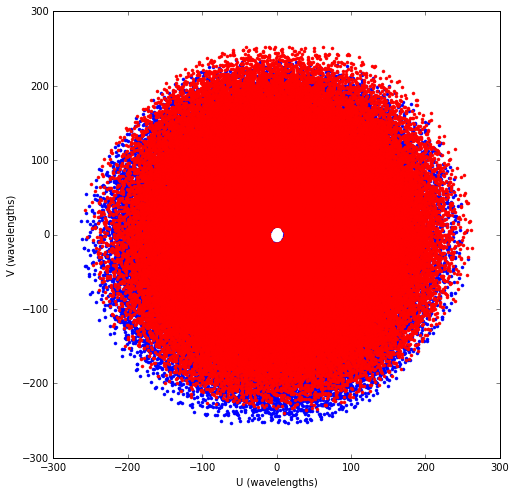

In [5]:
if doplot:
    plt.clf()
    for f in frequency:
        x = f / const.c
        plt.plot(x * vt.data['uvw'][:, 0], x * vt.data['uvw'][:, 1], '.', color='b')
        plt.plot(-x * vt.data['uvw'][:, 0], -x * vt.data['uvw'][:, 1], '.', color='r')
        plt.xlabel('U (wavelengths)')
        plt.ylabel('V (wavelengths)')

Create a grid of components and predict each in turn, using the full phase term including w.

In [6]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'image_partitions':4}

flux = numpy.array([[100.0]])
vt.data['vis'] *= 0.0

model = create_image_from_visibility(vt, params=params)
spacing_pixels = params['npixel'] // params['image_partitions']
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * params['cellsize'] * spacing_pixels / numpy.pi
centers = -1.5, -0.5, +0.5, +1.5
for iy in centers:
    for ix in centers:
        pra =  int(round(params['npixel'] // 2 + ix * spacing_pixels - 1))
        pdec = int(round(params['npixel'] // 2 + iy * spacing_pixels - 1))
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc)
        predict_skycomponent_visibility(vt, comp)

Make the dirty image and point spread function. 

Note that the shape of the sources vary with position in the image. This space-variant property of the PSF arises from the w-term.

In [7]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8}

dirty = create_image_from_visibility(vt, params=params)
vt, _, _ = weight_visibility(vt, dirty)
dirty, sumwt = invert_2d(vt, dirty, params=params)
dirty.data = dirty.data / sumwt
if doplot:
    show_image(dirty)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

export_image_to_fits(dirty, 'imaging-wterm_dirty.fits')

AttributeError: 'tuple' object has no attribute 'phasecentre'

This occurs because the Fourier transform relationship between sky brightness and visibility is only accurate over small fields of view. 

Hence we can make an accurate image by partitioning the image plane into small regions, treating each separately and then glueing the resulting partitions into one image. We can this image plane partitioning (aka faceting).

In [ ]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'image_partitions': 4}


dirtyFacet = create_image_from_visibility(vt, params=params)
dirtyFacet, sumwt = invert_by_image_partitions(vt, dirtyFacet, image_iterator=raster_iter, params=params)
dirtyFacet.data = dirtyFacet.data / sumwt

if doplot:
    show_image(dirtyFacet)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyFacet.data.max(), dirtyFacet.data.min(), sumwt))
export_image_to_fits(dirtyFacet, 'imaging-wterm_dirtyFacet.fits')

That was the best case. This time, we will not arrange for the partitions to be centred on the sources. 

In [ ]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'image_partitions':2}

dirtyFacet2 = create_image_from_visibility(vt, params=params)
dirtyFacet2, sumwt = invert_by_image_partitions(vt, dirtyFacet2, image_iterator=raster_iter, params=params)
dirtyFacet2.data = dirtyFacet2.data / sumwt

if doplot:
    show_image(dirtyFacet2)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyFacet2.data.max(), dirtyFacet2.data.min(), sumwt))
export_image_to_fits(dirtyFacet2, 'imaging-wterm_dirtyFacet2.fits')

The w-term can also be viewed as a time-variable distortion. 

To illustrate this, we will construct images as a function of time. For comparison, we show difference of each time slice from the best facet image. Instantaneously the sources are un-distorted but do lie in the wrong location.

In [ ]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'timeslice': 1.0}

for rows in vis_timeslice_iter(vt, params):
    visslice = vt.select_rows(rows)
    dirtySnapshot = create_image_from_visibility(visslice, params=params)
    dirtySnapshot, sumwt = invert_2d(visslice, dirtySnapshot, params=params)

    dirtySnapshot.data /= sumwt

    print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
          (dirtySnapshot.data.max(), dirtySnapshot.data.min(), sumwt))
    if doplot:
        dirtySnapshot.data -= dirtyFacet.data
        show_image(dirtySnapshot)
        plt.title("Hour angle %.2f hours" % (numpy.average(visslice.time) * 12.0 / 43200.0))
        plt.show()

This timeslice imaging leads to a straightforward algorithm in which we correct each time slice and then sum the resulting timeslices. 

This lends itself to parallel processing, so we do this in parallel using 4 processes

In [ ]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'timeslice': 1.0,
          'nprocessor':4, 
          'padding':2}

dirtyTimeslice = create_image_from_visibility(vt, params=params)
dirtyTimeslice, sumwt= invert_timeslice(vt, dirtyTimeslice, params=params)

dirtyTimeslice.data /= sumwt
show_image(dirtyTimeslice)
plt.show()

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
      (dirtyTimeslice.data.max(), dirtyTimeslice.data.min(), sumwt))

export_image_to_fits(dirtyTimeslice, 'imaging-wterm_dirty_Timeslice.fits')

Finally we try w projection. 

The w term in multiplicative in the image plane, parametrised by w. In this plot, we use the median of the absolute value of w.

In [ ]:
if doplot:
    wterm = create_w_term_image(vt, params=params)
    show_image(wterm)
    plt.show()

This can be restated as a convolution in Fourier space. 

Hence when gridding, we can use the transform of the w beam to correct this effect while gridding. 

In [ ]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'padding':1,
          'oversampling':4,
          'nprocessor':4,
          'wstep':10.0, 
          'kernelwidth':16
         }


dirtyWProjection = create_image_from_visibility(vt, params=params)
dirtyWProjection, sumwt = invert_wprojection(vt, dirtyWProjection, params=params)
dirtyWProjection.data = dirtyWProjection.data / sumwt

if doplot:
    show_image(dirtyWProjection)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyWProjection.data.max(), 
                                                             dirtyWProjection.data.min(), sumwt))
export_image_to_fits(dirtyWProjection, 'imaging-wterm_dirty_WProjection.fits')
